# Data Scientist Associate Practical Exam Submission

![Elephant](img\geert-pieters-AfgJpWQH4lw-unsplash.jpg){width=800}


## Introduction

GoalZone has fitness clubs in Canada and offers classes for 25 or 15 people. The problem is, even when classes are full, not everyone shows up. So, GoalZone wants to figure out who'll come and who won't. If they can guess someone won't show, they can give that spot to someone else. This could help more people attend and make the most of each class

## Business Problem

GoalZone's issue is that even when their classes are fully booked, they don't always have a full turnout. This means that even if all spots are taken, not everyone who signed up actually comes. Because of this, GoalZone wants to find a way to predict if someone will show up or not. If they can guess accurately, they can offer that spot to someone else, making the most of their class sizes and maybe increasing attendance.

**Problem**
- Low turnout in fully booked classes at GoalZone, leading to wasted spots and the need to predict member attendance to make classes more efficient.

**Consequences**

- **Wasted Spots**: Even with full bookings, not all seats are filled due to low turnout.
- **Lost Revenue**: Every empty spot could be lost money if they charge per class.
- **Customer Dissatisfaction**: Members might get upset if they can't book classes that end up having empty spots.
- **Inefficient Operating Costs**: The company pays fixed costs for classes that aren't fully used.


**Project main goal**

- Optimize class occupancy, cutting down on wasted spots, to boost revenue and enhance customer satisfaction.
- We'll need to predict if a member will attend (1) or skip (0) a class, a binary classification issue. The model will categorize each booking into one of these two groups using the features provided in the data.


## Trade-off

Before building our model, we need to figure out the trade-offs the business will face. This way, we can select the best metric to judge our model's performance and understand its true impact.

Think of our prediction model as a gym teacher trying to guess if a student will show up for the next class or not.

- False Positives: The teacher thinks, "Oh, this student will definitely come to the next class!" But then, the student doesn't show. Oops! The teacher was overly optimistic.
- False Negatives: The teacher assumes, "This student won't be attending the next class," but lo and behold, the student walks in, ready for the workout. This time, the teacher was too pessimistic.

Now, the challenge: If the teacher always tries to avoid false positives, he might end up thinking no one will attend the next class. Sounds safe, right? But it's not ideal. Because in doing so, he's making a lot of false negative mistakes.

That's the trade-off: minimizing one type of error can increase the other. For our problem, we want the teacher to accurately estimate how many students will attend to ensure classes are neither empty nor overcrowded. Striking this balance is key!

## Which one is worse?

**False Positives (predicting a member will attend when they don't):**

- Wasted Spots: This can lead to unoccupied spots in classes, especially if the company is cautious and avoids overbooking because of these predictions.
- Lost Revenue Opportunities: If the company charges per class, every empty spot represents lost income.
- Dissatisfaction of Waitlisted Members: Those on a waiting list might be upset when they find out they could've attended a "full" class that had unclaimed spots.

**False Negatives (predicting a member won't attend when they do):**

- Excessive Overbooking: This can result in more members showing up for a class than there's room for.
- Member Dissatisfaction: Members might be unhappy about not having adequate space in class or feeling it's too crowded.
- Compensations or Refunds: The company might have to give compensations, discounts, or refunds to affected members.
- Brand Reputation: Continued member dissatisfaction can harm the company's reputation in the long run.

Considering the impacts above, **false negatives** appear more costly since they directly impact member well-being and satisfaction, in addition to potential financial costs for the company.


>**That means we'll tolerate more false positives than false negatives.**

## Overview

Before anything, we'll perform a stratified split to maintain the proportion of classes in the dependent variable, using 85% for training and 15% for testing to prevent information leakage. Hence, the exploration was done only with the training set.

In this regard, we'll use sklearn pipelines to handle treatment, imputation, or possible transformations to facilitate its reuse later for production.

In [22]:
import numpy as np
import pandas as pd
import warnings

warnings.simplefilter(action="ignore")
pd.set_option("display.float_format", lambda x: "%.3f" % x)


SEED = 1234
TEST_SIZE = 0.1
VAL_SIZE = 0.2
TARGET = "attended"

# load data
df = pd.read_csv(
    r"C:\Users\Eric\Meu Drive\__Learning\fitness-class-prediction\data\raw\fitness_class_2212.csv"
)

# Split data
from sklearn.model_selection import train_test_split


def split_data(df, target, split_size, seed):
    # Split the data into training and testing sets while maintaining the class distribution of the target column.
    train, test = train_test_split(
        df, test_size=split_size, random_state=seed, stratify=df[target]
    )

    # Reset the indices of the resulting DataFrames for consistency.
    train, test = train.reset_index(drop=True), test.reset_index(drop=True)

    return train, test


train, test = split_data(df, target=TARGET, split_size=TEST_SIZE, seed=SEED)
train, valid = split_data(train, target=TARGET, split_size=VAL_SIZE, seed=SEED)

print("train shape: ", train.shape)
print("validation shape: ", valid.shape)
print("test shape: ", test.shape)

train shape:  (1080, 8)
validation shape:  (270, 8)
test shape:  (150, 8)


### Overview

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   booking_id        1080 non-null   int64  
 1   months_as_member  1080 non-null   int64  
 2   weight            1066 non-null   float64
 3   days_before       1080 non-null   object 
 4   day_of_week       1080 non-null   object 
 5   time              1080 non-null   object 
 6   category          1080 non-null   object 
 7   attended          1080 non-null   int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 67.6+ KB


In [25]:
train.head(5)

,booking_id,months_as_member,weight,days_before,day_of_week,time,category,attended
0,206,6,91.520,10,Fri,AM,HIIT,0
1,1283,19,83.960,10,Fri,AM,HIIT,0
2,884,10,83.370,3,Mon,AM,Strength,0
3,267,4,103.250,14,Sun,AM,HIIT,0
4,394,8,97.200,11,Sat,PM,Cycling,0


In [26]:
train.describe()

,booking_id,months_as_member,weight,attended
count,1080.000,1080.000,1066.000,1080.000
mean,755.773,15.527,82.510,0.303
std,434.755,12.892,12.894,0.460
min,1.000,1.000,55.410,0.000
25%,376.750,8.000,73.312,0.000
50%,750.500,12.000,80.725,0.000
75%,1129.500,19.000,89.535,1.000
max,1499.000,148.000,170.520,1.000


## Task 1: Data Integrity and Missing Values

We'll check the data based on the original source's c.

| Column Name       | Criteria                                                                                           |
|-------------------|---------------------------------------------------------------------------------------------------|
| booking_id        | Nominal. The unique identifier of the booking. Missing values are not possible due to the database structure. |
| months_as_member  | Discrete. The number of months as this fitness club member, minimum 1 month. Replace missing values with the overall average month. |
| weight            | Continuous. The member's weight in kg, rounded to 2 decimal places. The minimum possible value is 40.00 kg. Replace missing values with the overall average weight. |
| days_before       | Discrete. The number of days before the class the member registered, minimum 1 day. Replace missing values with 0. |
| day_of_week       | Nominal. The day of the week of the class. One of “Mon”, “Tue”, “Wed”, “Thu”, “Fri”, “Sat” or “Sun”. Replace missing values with “unknown”. |
| time              | Ordinal. The time of day of the class. Either “AM” or “PM”. Replace missing values with “unknown”. |
| category          | Nominal. The category of the fitness class. One of “Yoga”, “Aqua”, “Strength”, “HIIT”, or “Cycling”. Replace missing values with “unknown”. |
| attended          | Nominal. Whether the member attended the class (1) or not (0). Missing values should be removed. |


### 1a. State whether the values match the description given in the table above.

In [27]:
def validate_data(df: pd.DataFrame) -> dict:
    validation_results = {}

    # Helper function to check if a series contains only numeric data
    def is_numeric(series):
        return series.apply(lambda x: isinstance(x, (int, float))).all()

    # Validate booking_id
    no_missing = not df["booking_id"].isnull().any()
    all_unique = df["booking_id"].nunique() == len(df)
    if no_missing and all_unique:
        validation_results[
            "booking_id"
        ] = "Matches the description. No missing values, all unique."
    else:
        missing_str = "Missing values." if not no_missing else ""
        unique_str = "Not all unique." if not all_unique else ""
        validation_results["booking_id"] = f"Does not match. {missing_str} {unique_str}"

    # Validate months_as_member
    if is_numeric(df["months_as_member"]):
        min_val = df["months_as_member"].min()
        if min_val >= 1:
            validation_results[
                "months_as_member"
            ] = "Matches the description. No missing values, minimum value is 1."
        else:
            validation_results[
                "months_as_member"
            ] = f"Does not match. Minimum value is {min_val}."
    else:
        validation_results[
            "months_as_member"
        ] = "Does not match. Contains non-numeric values."

    # Validate weight
    if is_numeric(df["weight"]):
        min_weight = df["weight"].min()
        if min_weight >= 40:
            validation_results[
                "weight"
            ] = f"Matches the description. No missing values, minimum value is {min_weight:.2f} kg, rounded to 2 decimal places."
        else:
            validation_results[
                "weight"
            ] = f"Does not match. Minimum value is {min_weight:.2f} kg."
    else:
        validation_results["weight"] = "Does not match. Contains non-numeric values."

    # Validate days_before
    if is_numeric(df["days_before"]):
        min_days = df["days_before"].min()
        if min_days >= 1:
            validation_results[
                "days_before"
            ] = "Matches the description. No missing values, minimum value is 1."
        else:
            validation_results[
                "days_before"
            ] = f"Does not match. Minimum value is {min_days}."
    else:
        validation_results[
            "days_before"
        ] = "Does not match. Contains non-numeric values."

    # Validate day_of_week
    valid_day_values = df["day_of_week"].isin(
        ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    )
    if valid_day_values.all():
        validation_results[
            "day_of_week"
        ] = "Matches the description. No missing values."
    else:
        invalid_days = df.loc[~valid_day_values, "day_of_week"].unique()
        validation_results[
            "day_of_week"
        ] = f"Does not match. Contains invalid days: {', '.join(invalid_days)}."

    # Validate time
    valid_time_values = df["time"].isin(["AM", "PM"])
    if valid_time_values.all():
        validation_results[
            "time"
        ] = "Matches the description. No missing values, contains 'AM' and 'PM'."
    else:
        invalid_times = df.loc[~valid_time_values, "time"].unique()
        validation_results[
            "time"
        ] = f"Does not match. Contains invalid times: {', '.join(invalid_times)}."

    # Validate category
    valid_category_values = df["category"].isin(
        ["Yoga", "Aqua", "Strength", "HIIT", "Cycling"]
    )
    if valid_category_values.all():
        validation_results["category"] = "Matches the description. No missing values."
    else:
        invalid_categories = df.loc[~valid_category_values, "category"].unique()
        validation_results[
            "category"
        ] = f"Does not match. Contains invalid categories: {', '.join(invalid_categories)}."

    # Validate attended
    valid_attended_values = df["attended"].isin([0, 1])
    if valid_attended_values.all():
        validation_results[
            "attended"
        ] = "Matches the description. No missing values, contains 0 and 1."
    else:
        invalid_attends = df.loc[~valid_attended_values, "attended"].unique()
        validation_results[
            "attended"
        ] = f"Does not match. Contains invalid values: {', '.join(map(str, invalid_attends))}."

    return validation_results


validation_status = validate_data(train)
for col, status in validation_status.items():
    print(f"{col}: {status}")

booking_id: Matches the description. No missing values, all unique.
months_as_member: Matches the description. No missing values, minimum value is 1.
weight: Matches the description. No missing values, minimum value is 55.41 kg, rounded to 2 decimal places.
days_before: Does not match. Contains non-numeric values.
day_of_week: Does not match. Contains invalid days: Wednesday, Fri., Monday.
time: Matches the description. No missing values, contains 'AM' and 'PM'.
category: Does not match. Contains invalid categories: -.
attended: Matches the description. No missing values, contains 0 and 1.


### 1b. State the number of missing values in the column.

In [7]:
train.isna().sum()

booking_id           0
months_as_member     0
weight              17
days_before          0
day_of_week          0
time                 0
category             0
attended             0
dtype: int64

### 1c. Describe what you did to make values match the description if they did not match.

Using the CustomPreprocessor class:

- `category`: Replaced '-' values with 'unknown'.
- `day_of_week`: Abbreviated extended weekday names like 'Monday' to their three-letter format, e.g., 'Mon'.
- `days_before`: Extracted numerical values and adjusted its datatype for consistency.
- `weight`: Missing values or those below 50 were substituted with the column's median value calculated during the fitting process.

Additionally:

`attended`: RemoveMissingTarget was used to discard rows with missing values.
`months_as_member` and weight: AverageImputer filled in missing values with the average of the respective columns.
`days_before`: SimpleImputer was applied to replace missing values with 0.
`day_of_week`, time, and category: ConstantImputer was designated to replace their missing values with 'unknown'.

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
from src.utils import split_data
from sklearn import set_config

set_config(transform_output="pandas")


class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        """
        Calculate and store the median value of the 'weight' column.

        Parameters:
        - X: DataFrame. The input data.
        - y: Series or DataFrame, optional. Target variable(s). Not used in this transformer.

        Returns:
        - self: The transformer instance.
        """
        self.weight_median = X["weight"].median()
        return self

    def transform(self, X):
        """
        Apply various preprocessing steps to the input data.

        Parameters:
        - X: DataFrame. The input data.

        Returns:
        - X: DataFrame. The preprocessed data.
        """
        X = X.copy()

        # Replace '-' with 'unknown' in the 'category' column.
        X["category"] = X["category"].replace("-", "unknown")

        # Replace full weekday names with their abbreviations in the 'day_of_week' column.
        X["day_of_week"] = X["day_of_week"].replace(
            {"Monday": "Mon", "Wednesday": "Wed", "Fri.": "Fri"}
        )

        # Extract the numeric part from the 'days_before' column and convert it to an int16 data type.
        X["days_before"] = X["days_before"].str.extract(r"(\d+)").astype("int16")

        # Convert columns with 'object' data type to 'category' data type.
        # Add 'unknown' as a category if it's not already present.
        for col in X.select_dtypes("object").columns:
            X[col] = X[col].astype("category")
            categories = X[col].cat.categories.tolist()
            if "unknown" not in categories:
                categories.append("unknown")
                X[col] = X[col].cat.set_categories(categories)

        # Fill missing values if value is less then 40 in the 'weight' column with the median calculated during the fit.
        min_40_condition = (X["weight"].isnull()) | (X["weight"] < 40)
        X.loc[min_40_condition, "weight"] = self.weight_median
        return X


class RemoveMissingTarget(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.dropna(subset=["attended"])


# Custom transformer to replace missing values with a specified constant
class ConstantImputer(BaseEstimator, TransformerMixin):
    def __init__(self, constant):
        self.constant = constant

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.fillna(self.constant)


# Custom transformer to replace missing values with the overall average
class AverageImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.mean = X.mean()
        return self

    def transform(self, X):
        return X.fillna(self.mean)


# Preprocessing pipeline
ImputerPipeline = ColumnTransformer(
    transformers=[
        ("remove_missing_target", RemoveMissingTarget(), ["attended"]),
        ("impute_avg_months", AverageImputer(), ["months_as_member"]),
        ("impute_avg_weight", AverageImputer(), ["weight"]),
        (
            "impute_zero_days",
            SimpleImputer(strategy="constant", fill_value=0),
            ["days_before"],
        ),
        ("impute_unknown_day", ConstantImputer("unknown"), ["day_of_week"]),
        ("impute_unknown_time", ConstantImputer("unknown"), ["time"]),
        ("impute_unknown_category", ConstantImputer("unknown"), ["category"]),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

ImputerProcessor = Pipeline(
    steps=[
        ("imputer_pipeline", ImputerPipeline),
    ]
)

pipeline = Pipeline(
    steps=[
        ("custom_preprocessor", CustomPreprocessor()),
        ("imputer_preprocessor", ImputerProcessor),
    ]
)

# Apply pipeline
train_transformed = pipeline.fit_transform(train)
test_transformed = pipeline.transform(test)
valid_transformed = pipeline.transform(valid)

**Data Validation**

In [29]:
validation_status = validate_data(train_transformed)
for col, status in validation_status.items():
    print(f"{col}: {status}")

booking_id: Matches the description. No missing values, all unique.
months_as_member: Matches the description. No missing values, minimum value is 1.
weight: Matches the description. No missing values, minimum value is 55.41 kg, rounded to 2 decimal places.
days_before: Matches the description. No missing values, minimum value is 1.
day_of_week: Matches the description. No missing values.
time: Matches the description. No missing values, contains 'AM' and 'PM'.
category: Does not match. Contains invalid categories: unknown.
attended: Matches the description. No missing values, contains 0 and 1.


As we can see, the changes made meet all the guidelines. For the 'category' column, we have the string 'unknown' which is allowed by the original guidelines.

## Task 2: Visualization of Bookings Attended


### 2a. State which category of the variable attended has the most observations

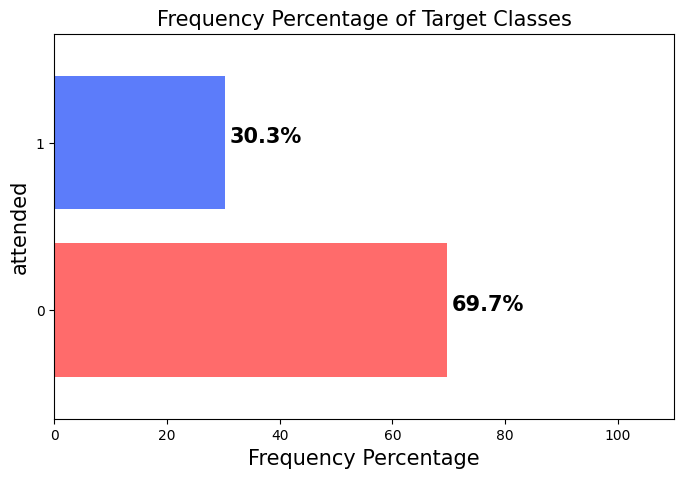

attended
0    753
1    327
Name: count, dtype: int64

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define bar colors based on the index (0 or 1)
custom_colors = ["#ff6b6b", "#5c7cfa"]

# Plot frequency percentages barplot
train["attended"].value_counts(normalize=True).mul(100).plot(
    kind="barh", color=custom_colors, width=0.8, figsize=(8, 5)
)

# Add frequency percentages to the plot
labels = train["attended"].value_counts(normalize=True).mul(100).round(1)
for i in labels.index:
    plt.text(labels[i] + 0.9, i, str(labels[i]) + "%", fontsize=15, weight="bold")

plt.xlim([0, 110])
plt.xticks(rotation=0)
plt.xlabel("Frequency Percentage", fontsize=15)
plt.ylabel("attended", fontsize=15)
plt.title("Frequency Percentage of Target Classes", fontsize=15)
plt.show()

train["attended"].value_counts()

70% of people skip class. For a class of 25, this means about 18 won't show up.

### 2b. Explain whether the observations are balanced across categories of the variable attended

Many people at GoalZone book classes but don't show up. Out of 753 bookings, 889 people skip, which is 70%. Only 327 people come, which is 30%.

If there's a class with 25 seats, around 17 seats will be empty. In a smaller class with 15 seats, about 10 will be empty.

This shows GoalZone has a problem with people booking and not coming. They need to fix this to use resources better and make more money.

## Task 3: Distribution of the Number of Months as a Member

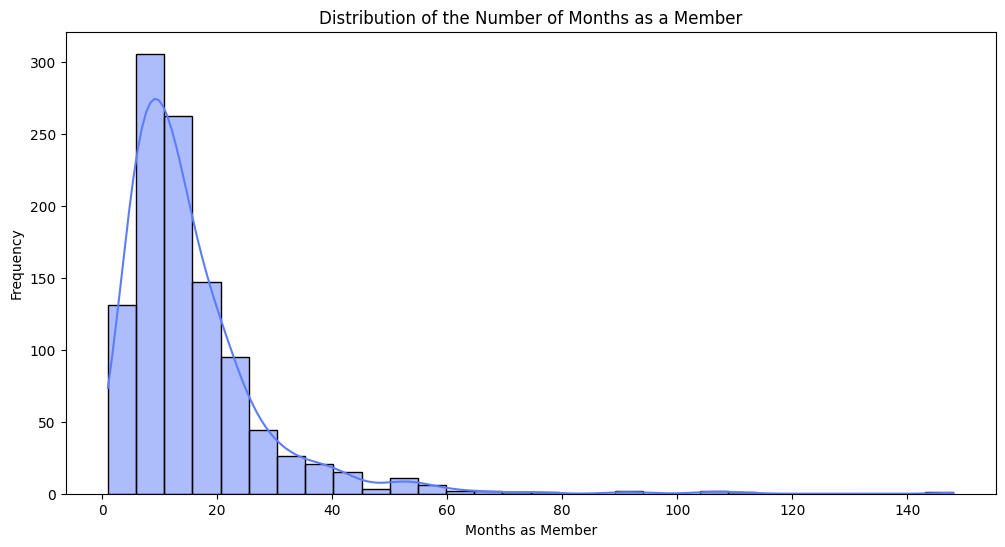

In [31]:
# Create a histogram for 'months_as_member'
plt.figure(figsize=(12, 6))

sns.histplot(train["months_as_member"], bins=30, color=custom_colors[1], kde=True)

plt.title("Distribution of the Number of Months as a Member")

plt.xlabel("Months as Member")

plt.ylabel("Frequency")

plt.show()

The distribution of the number of months as a member appears to be right-skewed. Most members have been part of the fitness club for a shorter period, specifically between 1 and 20 months. The frequency decreases as the number of months increases, with fewer members having been part of the club for an extended period.

This could signal a need for the fitness club to focus on retention strategies to keep members engaged and loyal, rather than just attracting new sign-ups. In simpler terms, the gym is good at getting people in the door but not so great at keeping them coming back year after year.


## Task 4: Relationship between Attendance and Number of Months as a Member

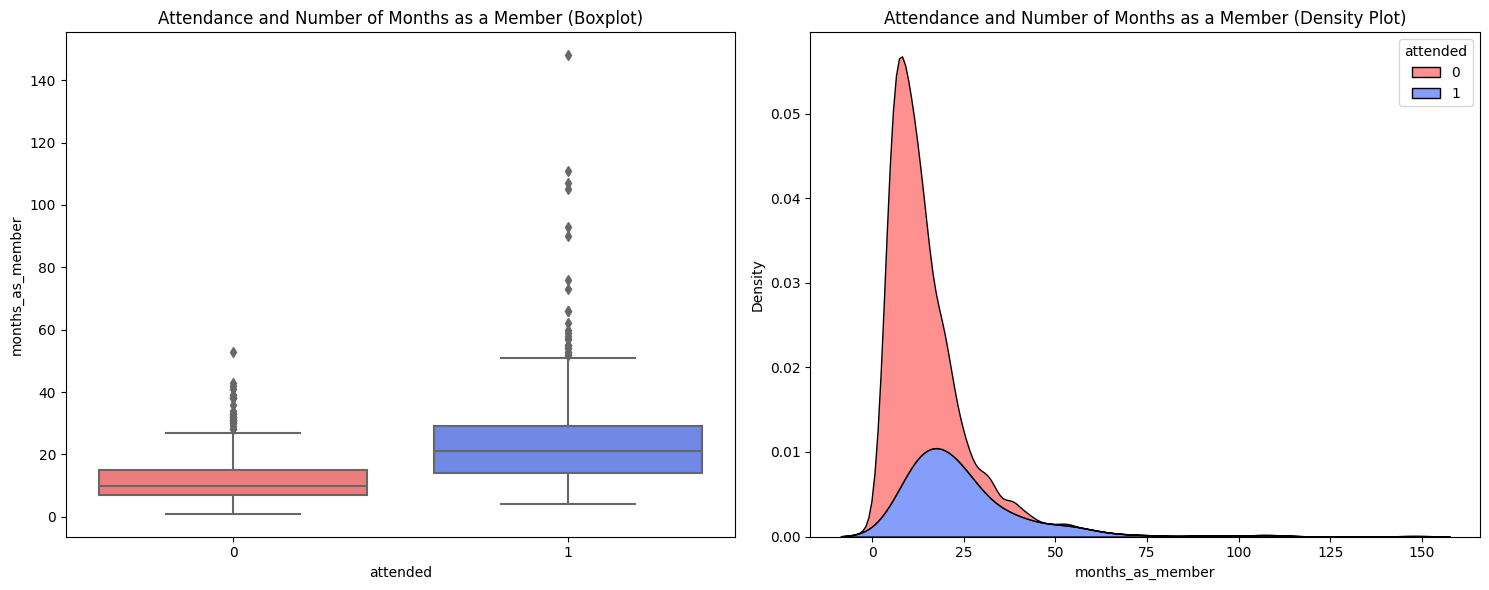

In [32]:
def plot_side_by_side(data, x_col, y_col, hue_col, custom_colors, title):
    """
    Create side-by-side plots using sns.boxplot and sns.displot with custom colors and title.

    Parameters:
        - data (DataFrame): The data to plot
        - x_col (str): The column to use for the x-axis in both plots
        - y_col (str): The column to use for the y-axis in the boxplot
        - hue_col (str): The column to use for hue in the displot
        - custom_colors (dict): A dictionary mapping hue levels to colors
        - title (str): The title for the plots
    """

    # Initialize figure for boxplot
    plt.figure(figsize=(15, 6))

    # Create the boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(data=data, x=x_col, y=y_col, palette=custom_colors)
    plt.title(f"{title} (Boxplot)")

    # Create the displot
    plt.subplot(1, 2, 2)
    sns.kdeplot(
        data=data, x=y_col, hue=hue_col, multiple="stack", palette=custom_colors
    )
    plt.title(f"{title} (Density Plot)")

    # Adjust layout for better visibility
    plt.tight_layout()
    plt.show()


# Call the function again with the example data
plot_side_by_side(
    train,
    "attended",
    "months_as_member",
    "attended",
    custom_colors,
    title="Attendance and Number of Months as a Member",
)

The median number of months as a member is slightly higher for those who attended the class compared to those who did not. However, the IQR for both groups overlap significantly, indicating that, while there might be a statistically significant difference, the magnitude of that difference might not be very large.

In [33]:
import scipy.stats as stats

# Perform an ANOVA test to compare the means of 'months_as_member' between the 'attended' and 'not-attended' groups
attended_group = train[train["attended"] == 1]["months_as_member"]
not_attended_group = train[train["attended"] == 0]["months_as_member"]


# Null Hypothesis: The means of 'months_as_member' are equal across all groups of 'attended'.
# Alternative Hypothesis: At least one group mean of 'months_as_member' is different from the others.

# ANOVA test

# Define the function for performing ANOVA and explaining the results


def perform_anova_and_explain(attended_group, not_):
    # Perform the ANOVA test

    f_statistic, p_value = stats.f_oneway(attended_group, not_attended_group)

    # Print the explanation of the results

    print("ANOVA Test Results:")

    print(f"F-Statistic: {f_statistic}")

    print(f"P-Value: {p_value}")

    print("\nHypotheses:")

    print(
        "Null Hypothesis: The means of 'months_as_member' are equal across all groups of 'attended'."
    )

    print(
        "Alternative Hypothesis: At least one group mean of 'months_as_member' is different from the others."
    )

    if p_value < 0.05:
        print("\nConclusion:")

        print(
            f"Given the extremely low p-value of {p_value}, we can emphatically reject the null hypothesis."
        )

        print(
            "This means that there is a statistically significant difference in the number of months as a member between those who attended and those who did not attend classes."
        )

    else:
        print("\nConclusion:")

        print(
            "The p-value is not less than 0.05, so we fail to reject the null hypothesis."
        )

        print(
            "This means that we do not have enough evidence to say that the number of months as a member is different between those who attended and those who did not attend classes."
        )


perform_anova_and_explain(attended_group, not_attended_group)

ANOVA Test Results:
F-Statistic: 320.13909514165243
P-Value: 6.825736512548438e-63

Hypotheses:
Null Hypothesis: The means of 'months_as_member' are equal across all groups of 'attended'.
Alternative Hypothesis: At least one group mean of 'months_as_member' is different from the others.

Conclusion:
Given the extremely low p-value of 6.825736512548438e-63, we can emphatically reject the null hypothesis.
This means that there is a statistically significant difference in the number of months as a member between those who attended and those who did not attend classes.


So the difference isn't likely due to just random variation in the sample; there's a genuine difference between classes.

## Task 5: Type of Machine Learning Problem and Metric Definition

The goal is to identify members who are most likely not to show up, and then take action. So, we need to make sure that the likelihood linked to each member is trustworthy.

As mentioned earlier, we decided that false negatives are more costly for the business. A common way to choose our model would be using Recall. The issue is that the chances given by classifiers aren't always set up to provide actual event probabilities. One way to fix this is by using Brier Scores. Making sure our model is well-calibrated can ensure that high probabilities of the positive class genuinely belong to the positive class.

## Task 6 and 7: Baseline and Comparison

We're going to test different models by using a method called stratified cross-validation, splitting the training data into 5 parts. We will compare four models: a basic one (dummy), logistic regression, random forest, and xgboost.

In [40]:
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    make_scorer,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    roc_auc_score,
    brier_score_loss,
    log_loss,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import load_train_test
import warnings
import xgboost as xgb

set_config(transform_output="pandas")


def apply_threshold_to_probabilities(test_df, prob_col_name, threshold):
    test_df["pred_status"] = test_df[prob_col_name].apply(
        lambda x: 1 if x > threshold else 0
    )
    return test_df


def evaluate_models(
    models, X_train, y_train, cv_splits=5, scoring_metrics=None, seed=None
):
    if scoring_metrics is None:
        scoring_metrics = {
            "log_loss": make_scorer(log_loss),
            "brier_loss": make_scorer(brier_score_loss),
            "precision": make_scorer(precision_score),
            "recall": make_scorer(recall_score),
            "f1": make_scorer(f1_score),
            "accuracy": make_scorer(accuracy_score),
            "roc_auc": make_scorer(roc_auc_score),
        }

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=seed)

    results = []
    for model_name, pipeline, Model, model_params in models:
        try:
            model = make_pipeline(pipeline, Model(**model_params, random_state=seed))
            scores = cross_validate(
                model, X_train, y_train, scoring=scoring_metrics, cv=cv, n_jobs=-1
            )
            mean_scores = {
                metric: scores[f"test_{metric}"].mean() for metric in scoring_metrics
            }
            result = {"Classifier": model_name, **mean_scores}
            results.append(result)
        except Exception as e:
            print(f"Error evaluating classifier {model_name}: {e}")

    df_results = pd.DataFrame(results).round(3)
    return df_results


def threshold_predictions(proba, threshold):
    return (proba >= threshold).astype(int)


def plot_confusion_matrix(
    y_true,
    y_pred,
    labels=["Not-Attended", "Attended"],
    title="Confusion Matrix",
    cmap="Blues",
    fontsize=14,
):
    cm = confusion_matrix(y_true, y_pred)

    if labels is None:
        labels = [str(i) for i in range(len(cm))]

    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.4)
    ax = sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap=cmap,
        cbar=False,
        xticklabels=labels,
        yticklabels=labels,
        annot_kws={"size": fontsize, "ha": "center", "va": "center"},
    )

    for t in ax.texts:
        t.set_text(t.get_text() + " ")  # Add a small space for better alignment

    plt.xlabel("Predicted", fontsize=fontsize)
    plt.ylabel("True", fontsize=fontsize)
    plt.title(title, fontsize=fontsize + 2, pad=20)
    plt.tight_layout()
    plt.show()


X_train, y_train = train_transformed.drop(columns=TARGET), train_transformed[TARGET]
X_test, y_test = test_transformed.drop(columns=TARGET), test_transformed[TARGET]
X_valid, y_valid = valid_transformed.drop(columns=TARGET), valid_transformed[TARGET]


# Column types
drop_cols = ["booking_id"]
cat_cols = train_transformed.select_dtypes("category").columns.tolist()

# Preprocess
cat_pipe = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", sparse=False),
)

# Baseline
baseline_prep = make_column_transformer(
    (cat_pipe, cat_cols),
    ("drop", drop_cols),
    remainder="passthrough",
    verbose_feature_names_out=False,
)

balanced_models = [
    ("Dummy Stratified", baseline_prep, DummyClassifier, {"strategy": "stratified"}),
    (
        "Random Forest",
        baseline_prep,
        RandomForestClassifier,
        {"class_weight": "balanced"},
    ),
    (
        "Logistic Regression",
        baseline_prep,
        LogisticRegression,
        {"class_weight": "balanced", "max_iter": 100},
    ),
    ("XGBoost", baseline_prep, xgb.XGBClassifier, {"scale_pos_weight": 2}),
]


balanced_results = evaluate_models(balanced_models, X_train, y_train, seed=SEED)
balanced_results.sort_values(by=["brier_loss"], ascending=True)

,Classifier,log_loss,brier_loss,precision,recall,f1,accuracy,roc_auc
1,Random Forest,8.911,0.247,0.616,0.492,0.547,0.753,0.679
2,Logistic Regression,9.044,0.251,0.575,0.667,0.617,0.749,0.726
3,XGBoost,9.445,0.262,0.564,0.584,0.574,0.738,0.694
0,Dummy Stratified,15.919,0.442,0.303,0.352,0.325,0.558,0.500


## Task 8: Explain Why You Chose


1. **Logistic Regression**: This model was chosen as a baseline because it is simple, interpretable, and commonly used for binary classification problems.
2. **Random Forest Classifier**: This model was chosen for comparison because it is a powerful ensemble method capable of capturing complex patterns and is generally less prone to overfitting.


## Task 9: Compare the Performance of the Two Models

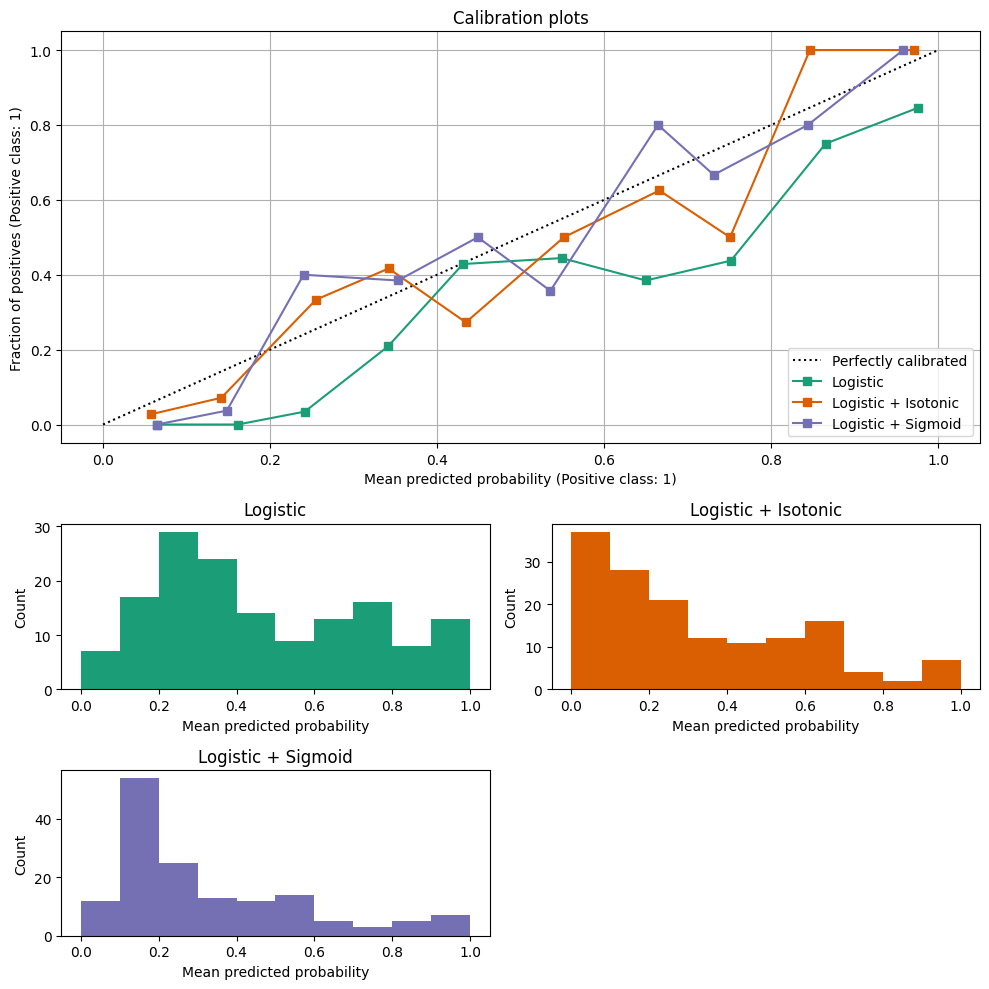

In [39]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibrationDisplay


def plot_calibration_curves(clf_list, X_train, y_train, X_test, y_test):
    """
    Plot calibration curves for given classifiers.

    Parameters:
    clf_list : list of tuples
        Each tuple contains the classifier and its name.
    X_train : array-like
        Training data features.
    y_train : array-like
        Training data labels.
    X_test : array-like
        Test data features.
    y_test : array-like
        Test data labels.
    """
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)
    colors = plt.get_cmap("Dark2")

    ax_calibration_curve = fig.add_subplot(gs[:2, :2])
    calibration_displays = {}

    for i, (clf, name) in enumerate(clf_list):
        clf.fit(X_train, y_train)
        display = CalibrationDisplay.from_estimator(
            clf,
            X_test,
            y_test,
            n_bins=10,
            name=name,
            ax=ax_calibration_curve,
            color=colors(i),
        )
        calibration_displays[name] = display

    ax_calibration_curve.grid()
    ax_calibration_curve.set_title("Calibration plots")

    grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
    for i, (_, name) in enumerate(clf_list):
        row, col = grid_positions[i]
        ax = fig.add_subplot(gs[row, col])

        ax.hist(
            calibration_displays[name].y_prob,
            range=(0, 1),
            bins=10,
            label=name,
            color=colors(i),
        )
        ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

    plt.tight_layout()
    plt.show()


# Calibrate probabilities
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

lr = make_pipeline(
    baseline_prep,
    LogisticRegression(random_state=SEED, class_weight="balanced", max_iter=1000),
)

lr_sigmoid = CalibratedClassifierCV(lr, method="sigmoid", cv=cv)
lr_isotonic = CalibratedClassifierCV(lr, method="isotonic", cv=cv)

lr_clf_list = [
    (lr, "Logistic"),
    (lr_isotonic, "Logistic + Isotonic"),
    (lr_sigmoid, "Logistic + Sigmoid"),
]

plot_calibration_curves(lr_clf_list, X_train, y_train, X_test, y_test)

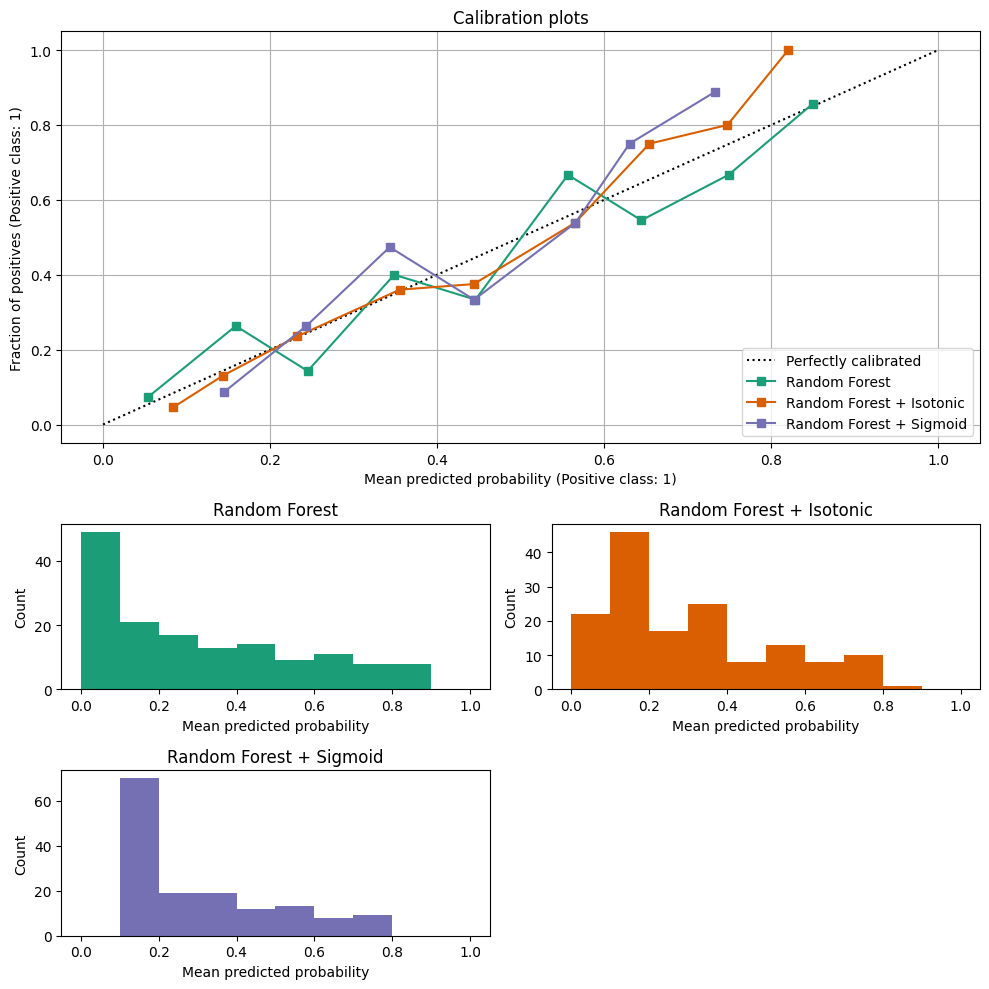

In [38]:
rf = make_pipeline(
    baseline_prep,
    RandomForestClassifier(
        random_state=SEED,
        class_weight="balanced",
    ),
)

rf_sigmoid = CalibratedClassifierCV(rf, method="sigmoid", cv=cv)
rf_isotonic = CalibratedClassifierCV(rf, method="isotonic", cv=cv)

rf_clf_list = [
    (rf, "Random Forest"),
    (rf_isotonic, "Random Forest + Isotonic"),
    (rf_sigmoid, "Random Forest + Sigmoid"),
]

plot_calibration_curves(rf_clf_list, X_train, y_train, X_test, y_test)

## Task 10: Explain Which Model Performs Better and Why

- Performance: Both models perform relatively similarly with an accuracy around 75%. However, the Random Forest has a slightly better accuracy (0.753 vs. 0.749) and precision (0.616 vs. 0.575).
- Class Identification: Logistic Regression is better at identifying the positive class with a higher recall (0.667 vs. 0.492) and also has a higher F1 score (0.617 vs. 0.547).
- Probabilistic Predictions: Random Forest provides slightly more certain predictions with a lower log loss and brier loss.
- Model Robustness: Logistic Regression is more stable and might work better in different situations. It has a score of 0.726, which is higher than Random Forest's 0.679.


Since we care about how true the probabilities are, we'll focus on the brier score. We've seen that the Random Forest has a lower score, so it might be a bit better. But to be sure, we'll look into it more deeply.

When we look at it, we can see that the Random Forest has more even probabilities in its Sigmoid version.

In [55]:
def expected_calibration_error(y, proba, bins="fd"):
    bin_count, bin_edges = np.histogram(proba, bins=bins)
    n_bins = len(bin_count)
    bin_edges[0] -= 1e-8  # because left edge is not included
    bin_id = np.digitize(proba, bin_edges, right=True) - 1
    bin_ysum = np.bincount(bin_id, weights=y, minlength=n_bins)
    bin_probasum = np.bincount(bin_id, weights=proba, minlength=n_bins)
    bin_ymean = np.divide(
        bin_ysum, bin_count, out=np.zeros(n_bins), where=bin_count > 0
    )
    bin_probamean = np.divide(
        bin_probasum, bin_count, out=np.zeros(n_bins), where=bin_count > 0
    )
    ece = np.abs((bin_probamean - bin_ymean) * bin_count).sum() / len(proba)
    return ece


def calculate_ece_for_models(y_test, model_probabilities):
    """
    Calculate the Expected Calibration Error (ECE) for multiple models.

    Parameters:
    - y_test: Ground truth (correct) target values.
    - model_probabilities: Dictionary where keys are model names and values are predicted probabilities.

    Returns:
    - ece_dict: Dictionary where keys are model names and values are their respective ECE.
    """
    ece_dict = {}
    for model_name, prob in model_probabilities.items():
        ece = expected_calibration_error(y_test, prob)
        ece_dict[model_name] = ece
    return ece_dict


lr.fit(X_train, y_train.values.ravel())

y_pred_lr = lr.predict(X_valid)
y_prob_lr = lr.predict_proba(X_valid)[:, 1]


lr_isotonic.fit(X_train, y_train)
y_prob_isotonic_lr = lr_isotonic.predict_proba(X_valid)[:, 1]

lr_sigmoid.fit(X_train, y_train)
y_prob_sigmoid_lr = lr_sigmoid.predict_proba(X_valid)[:, 1]

lr_model_probabilities = {
    "Original": y_prob_lr,
    "Isotonic": y_prob_isotonic_lr,
    "Sigmoid": y_prob_sigmoid_lr,
}


# Calculate ECE for each model
ece_results = calculate_ece_for_models(y_valid, lr_model_probabilities)

# Print ECE results
for model, ece in ece_results.items():
    print(f"Expected Calibration Error for {model}: {ece:1.4f}")

Expected Calibration Error for Original: 0.1289
Expected Calibration Error for Isotonic: 0.0606
Expected Calibration Error for Sigmoid: 0.0608


In [54]:
rf.fit(X_train, y_train.values.ravel())

y_pred_rf = rf.predict(X_valid)
y_prob_rf = rf.predict_proba(X_valid)[:, 1]


rf_isotonic.fit(X_train, y_train)
y_prob_isotonic_rf = rf_isotonic.predict_proba(X_valid)[:, 1]

rf_sigmoid.fit(X_train, y_train)
y_prob_sigmoid_rf = rf_sigmoid.predict_proba(X_valid)[:, 1]

rf_model_probabilities = {
    "Original": y_prob_rf,
    "Isotonic": y_prob_isotonic_rf,
    "Sigmoid": y_prob_sigmoid_rf,
}


# Calculate ECE for each model
ece_results = calculate_ece_for_models(y_valid, rf_model_probabilities)

# Print ECE results
for model, ece in ece_results.items():
    print(f"Expected Calibration Error for {model}: {ece:1.4f}")

Expected Calibration Error for Original: 0.0671
Expected Calibration Error for Isotonic: 0.0468
Expected Calibration Error for Sigmoid: 0.0406


When we checked the overall error, we found out that the RF + sigmoid model is the best for trustworthy probabilities

In [67]:
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]
y_prob_isotonic_rf = rf_isotonic.predict_proba(X_test)[:, 1]
y_prob_sigmoid_rf = rf_sigmoid.predict_proba(X_test)[:, 1]


print("Brier Score:", brier_score_loss(y_test, y_prob_isotonic_rf).round(3))
print("Log Loss:", log_loss(y_test, y_prob_isotonic_rf).round(3))

Brier Score: 0.154
Log Loss: 0.473


### Final evaluation

In [71]:
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]
y_prob_isotonic_rf = rf_isotonic.predict_proba(X_test)[:, 1]
y_prob_sigmoid_rf = rf_sigmoid.predict_proba(X_test)[:, 1]


print("Sigmoid")
print("Brier Score:", brier_score_loss(y_test, y_prob_sigmoid_rf).round(3))
print("Log Loss:", log_loss(y_test, y_prob_sigmoid_rf).round(3))

print("\nIsotonic")
print("Brier Score:", brier_score_loss(y_test, y_prob_isotonic_rf).round(3))
print("Log Loss:", log_loss(y_test, y_prob_isotonic_rf).round(3))

Sigmoid
Brier Score: 0.155
Log Loss: 0.479

Isotonic
Brier Score: 0.154
Log Loss: 0.473


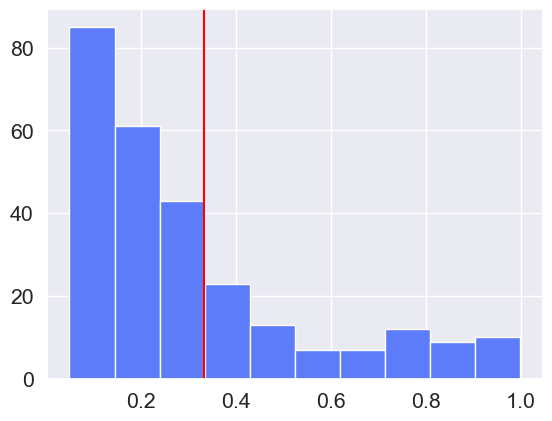

In [73]:
# Plot the predicted probabilities of default
plt.hist(y_prob_sigmoid_lr, color=custom_colors[1], bins=10)

# Calculate the threshold with quantile
threshold = np.quantile(y_prob_sigmoid_lr, 0.7)

# Add a reference line to the plot for the threshold
plt.axvline(x=threshold, color="red")
plt.show()

              precision    recall  f1-score   support

           0       0.86      0.80      0.83       105
           1       0.60      0.69      0.64        45

    accuracy                           0.77       150
   macro avg       0.73      0.74      0.73       150
weighted avg       0.78      0.77      0.77       150



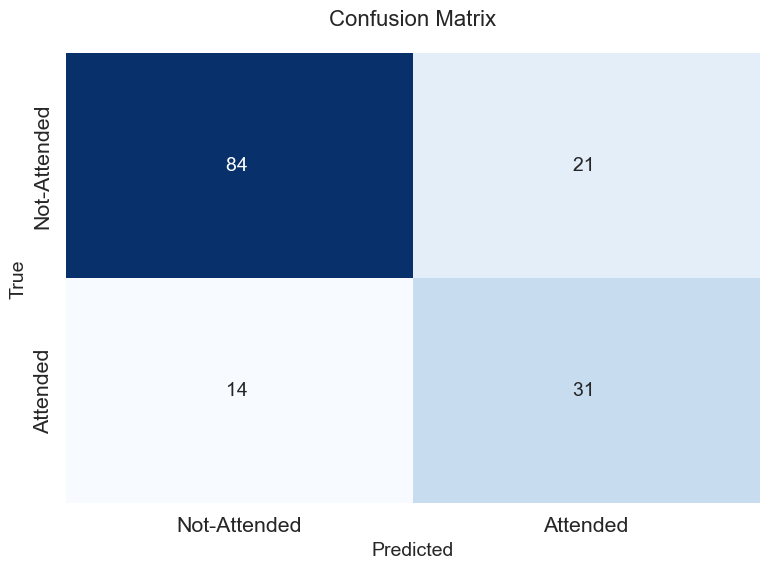

In [72]:
y_pred_isotonic = [1 if p > threshold else 0 for p in y_prob_sigmoid_rf]
print(classification_report(y_test, y_pred_isotonic))
plot_confusion_matrix(y_test, y_pred_isotonic)

Given our business problem, this means:

- The model is pretty good at guessing who will show up.
- It's a bit over-optimistic sometimes (because of its 60% precision for showing up).
- It's also reasonably alert, catching a good number of people who actually come (69% recall for showing up).

### Recommendations

Dynamic Waitlist System: This system notifies waitlisted members of available spots when it predicts some won't attend.

- Reacts to Changes: The system offers spots based on last-minute predictions.
-Flexible: Even last-minute cancellations can be managed.
- Accurate: Since this is close to the class time, it might be more in sync with real attendance.
- A Bit Complex: Needs to maintain a waitlist and inform members promptly.

Considering our model's results, the Dynamic Waitlist System seems a solid fit. The model is especially good at catching people who do show up (69 out of 100). So, if someone cancels, and the system predicts a waitlisted member will attend, there's a good chance they will!